In [2]:
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pprint
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
from scipy import stats
from scipy.interpolate import CubicSpline
from sklearn.metrics import mean_squared_error
import warnings
import itertools
warnings.filterwarnings("ignore")


Bad key "text.kerning_factor" on line 4 in
/opt/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Read SCFA and Bacteria absolute abundance

In [3]:
df_data = pd.read_csv('../DaiLab_data/SCFA_16S_combined.csv', index_col=0)
df_data.head()

,Mice_ID,Diet,Day,Acetate,Butyrate,Propionate,Muribaculaceae,Akkermansia-muciniphila,Bacteroides-acidifaciens,Bacteroides,...,Xanthobacteraceae,Lactococcus-raffinolactis,[Ruminococcus]-gnavus-group,Pseudarthrobacter,Clostridiales-bacterium-CIEAF-021,Bacilli,Faecalitalea,Bacteroides-sp.-Smarlab-3302398,Bradyrhizobium,Fusicatenibacter
sample401,GC1,0,0,21.066621,3.616159,5.810072,3.245292e+07,3.246751e+06,1.302268e+06,3.061871e+06,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sample402,GC2,0,0,7.774054,1.365244,1.830384,4.068548e+07,6.169465e+05,1.075532e+06,1.332868e+06,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sample403,GC3,0,0,11.285334,3.673223,2.370556,1.168489e+07,8.224048e+04,6.619684e+05,3.013237e+06,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sample404,GC4,0,0,7.833992,2.865009,1.700130,1.060346e+07,4.050830e+06,7.605208e+05,4.769099e+05,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sample405,GC5,0,0,6.596743,0.657688,1.500795,1.058594e+07,1.841478e+05,6.274667e+05,1.143251e+06,...,2557.608881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Normalize Bacteria and SCFA

In [4]:
scfa = ['Acetate','Butyrate','Propionate']
df_data_SCFA = df_data[['Mice_ID','Diet','Day']+scfa]
df_data_SCFA[scfa] /= df_data_SCFA[scfa].max().max()

In [5]:
bacterial_taxons = list(df_data.columns[6:])
df_data_bacteria = df_data[['Mice_ID','Diet','Day']+bacterial_taxons]
df_data_bacteria[bacterial_taxons] /= df_data_bacteria[bacterial_taxons].max().max()

# Add pseudo count

In [6]:
for idx in df_data_bacteria.index:
    sample = np.array(df_data_bacteria.loc[idx,bacterial_taxons])
    minval = np.min(sample[np.nonzero(sample)])
    sample[sample==0] = minval
    df_data_bacteria.loc[idx,bacterial_taxons] = sample

# Calculate log-derivatives

In [7]:
df_deriv_bacteria = deepcopy(df_data_bacteria)
for curr_mice in set(df_deriv_bacteria.Mice_ID):
    curr_df = df_deriv_bacteria[df_deriv_bacteria.Mice_ID==curr_mice]
    for taxon in bacterial_taxons:
        xdata = np.array(curr_df['Day'])
        ydata = np.array(curr_df[taxon])
        cs = CubicSpline(xdata, ydata)
        csd1 = cs.derivative(nu=1)
        ydata_d1 = csd1(xdata)
        df_deriv_bacteria.loc[df_deriv_bacteria.Mice_ID==curr_mice, taxon] = ydata_d1
df_deriv_bacteria.head()

,Mice_ID,Diet,Day,Muribaculaceae,Akkermansia-muciniphila,Bacteroides-acidifaciens,Bacteroides,Faecalibaculum,Parasutterella,Bacteroides-uniformis,...,Xanthobacteraceae,Lactococcus-raffinolactis,[Ruminococcus]-gnavus-group,Pseudarthrobacter,Clostridiales-bacterium-CIEAF-021,Bacilli,Faecalitalea,Bacteroides-sp.-Smarlab-3302398,Bradyrhizobium,Fusicatenibacter
sample401,GC1,0,0,-0.039503,-0.000391,-0.000402,-0.009355,0.000822,-0.000113,-0.000889,...,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,8.990907e-06,0.000009,0.000009,0.000009
sample402,GC2,0,0,-0.037876,-0.001241,0.000488,0.002158,0.004065,-0.000159,0.000364,...,-0.000006,-0.000006,-0.000006,-0.000006,-0.000006,-0.000006,-5.849542e-06,-0.000006,-0.000006,-0.000006
sample403,GC3,0,0,0.050822,0.003290,0.001587,0.016143,-0.021962,-0.003334,0.001784,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,9.741647e-07,0.000002,0.000002,0.000002
sample404,GC4,0,0,-0.035515,-0.028111,-0.000632,0.005183,-0.046272,-0.012519,0.000963,...,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-0.000004,-3.888164e-06,-0.000004,-0.000004,-0.000004
sample405,GC5,0,0,-0.032632,0.005597,0.003231,0.009709,-0.004968,-0.002279,0.000845,...,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-0.000001,-1.254145e-06,-0.000001,-0.000001,-0.000001


# Select the top 30 taxa group

In [8]:
topX =30
bacterial_taxons = bacterial_taxons[0:topX]
df_deriv_bacteria = df_deriv_bacteria[['Mice_ID','Diet','Day']+bacterial_taxons]
df_deriv_bacteria.head()

,Mice_ID,Diet,Day,Muribaculaceae,Akkermansia-muciniphila,Bacteroides-acidifaciens,Bacteroides,Faecalibaculum,Parasutterella,Bacteroides-uniformis,...,Rikenellaceae-RC9-gut-group,Lachnospiraceae-bacterium-10-1,Colidextribacter,Oscillibacter,Alistipes,Ruminococcaceae,Bacteroides-vulgatus-ATCC-8482,Roseburia,Rikenella,Anaerotruncus
sample401,GC1,0,0,-0.039503,-0.000391,-0.000402,-0.009355,0.000822,-0.000113,-0.000889,...,-0.003878,-0.030579,-0.005643,-0.002621,-0.003527,-0.004189,9.001144e-06,-0.000202,-0.000450,-0.007486
sample402,GC2,0,0,-0.037876,-0.001241,0.000488,0.002158,0.004065,-0.000159,0.000364,...,0.004805,-0.000188,-0.000975,-0.001832,0.004334,-0.005211,-5.837344e-06,-0.000064,0.004429,-0.005769
sample403,GC3,0,0,0.050822,0.003290,0.001587,0.016143,-0.021962,-0.003334,0.001784,...,-0.002769,-0.001014,-0.005705,-0.007394,0.000676,-0.003102,2.232260e-06,-0.003010,0.004737,-0.006119
sample404,GC4,0,0,-0.035515,-0.028111,-0.000632,0.005183,-0.046272,-0.012519,0.000963,...,0.002664,0.000155,0.000071,0.001271,0.017752,0.000242,-3.000140e-06,0.003136,0.005168,0.002720
sample405,GC5,0,0,-0.032632,0.005597,0.003231,0.009709,-0.004968,-0.002279,0.000845,...,0.021594,-0.000226,-0.006591,-0.005290,0.002285,-0.004936,4.407938e-07,-0.004368,0.004107,-0.003436


# Construct regression matrix

In [9]:
raw_F = df_deriv_bacteria[bacterial_taxons].transpose().values
raw_F

array([[-3.95034582e-02, -3.78763420e-02,  5.08219316e-02, ...,
         8.68300315e-02, -4.15160144e-02, -2.16163118e-02],
       [-3.90694928e-04, -1.24095105e-03,  3.28960986e-03, ...,
         2.41785926e-02, -8.80713457e-03,  1.03744023e-02],
       [-4.01938260e-04,  4.88074756e-04,  1.58663348e-03, ...,
         4.66130013e-04,  2.40343796e-04,  2.10180348e-04],
       ...,
       [-2.02197718e-04, -6.43098189e-05, -3.00995896e-03, ...,
         3.53949001e-05,  6.15732704e-05,  5.71171836e-06],
       [-4.49799396e-04,  4.42930120e-03,  4.73702808e-03, ...,
         9.14009749e-06,  4.61443348e-06,  4.63945324e-06],
       [-7.48605566e-03, -5.76941441e-03, -6.11854953e-03, ...,
        -8.89499000e-06,  3.25086662e-04,  3.79936190e-05]])

In [10]:
raw_Y_1 = np.reshape(np.array([1]*len(df_deriv_bacteria.index)), (-1,len(df_deriv_bacteria.index))) # growth rate, (1,247)
raw_Y_inulin = np.reshape(np.array(df_deriv_bacteria.Diet), (-1,len(df_deriv_bacteria.index))) # perturbation, (1,247)
raw_Y_SCFA = df_data_SCFA[['Acetate','Butyrate','Propionate']].transpose().values # scfa effect, (3, 247)
raw_Y_bacteria = df_data_bacteria[bacterial_taxons].transpose().values # bacteria-bacteria interaction, (30, 247)
raw_Y = np.concatenate((raw_Y_bacteria, raw_Y_1, raw_Y_inulin, raw_Y_SCFA))

# Test regression

In [11]:
D = np.zeros((raw_Y.shape[0], raw_Y.shape[0]))
np.fill_diagonal(D, [1]*raw_Y_bacteria.shape[0] + [2]*raw_Y_1.shape[0] + [0.5]*raw_Y_inulin.shape[0] + [0.3]*raw_Y_SCFA.shape[0])
Coef = np.matmul(np.matmul(raw_F,raw_Y.transpose()), np.linalg.inv(np.matmul(raw_Y, raw_Y.transpose())+D))

In [12]:
raw_F.shape[1]

247

# Cross-validation for choosing appropriate lambda combination

## search for global minimum

In [277]:
# penalty coefficients
lambda_bacteria = 10**(np.linspace(-2,2,21))
lambda_growth = 10**(np.linspace(-2,2,21))
lambda_perturbation = 10**(np.linspace(-2,2,21))
lambda_scfa = 10**(np.linspace(-2,2,21))

# data split
mcreps = 100
kfold=5
rn = range(1,raw_F.shape[1]+1)
kf = KFold(n_splits=kfold, shuffle=True)

lines = []
for l1,l2,l3,l4 in itertools.product(lambda_bacteria, lambda_growth, lambda_perturbation, lambda_scfa):
    mse = 0
    for m in np.arange(mcreps):
        for train_index, test_index in kf.split(rn):
            # get data split
            trainset_F = raw_F[:,train_index]
            trainset_Y = raw_Y[:,train_index]
            testset_F = raw_F[:,test_index]
            testset_Y = raw_Y[:,test_index]

            # train the model
            D = np.zeros((raw_Y.shape[0], raw_Y.shape[0]));
            np.fill_diagonal(D, [l1]*raw_Y_bacteria.shape[0] + [l2]*raw_Y_1.shape[0] + [l3]*raw_Y_inulin.shape[0] + [l4]*raw_Y_SCFA.shape[0])
            Coef = np.matmul(np.matmul(trainset_F,trainset_Y.transpose()), np.linalg.inv(np.matmul(trainset_Y, trainset_Y.transpose())+D))

            # mean square error of test dataset
            mse += mean_squared_error(testset_F, np.matmul(Coef,testset_Y))
    mse = mse/kfold/mcreps
    lines.append([l1,l2,l3,l4,mse])

df_cv = pd.DataFrame(lines, columns=['l1','l2','l3','l4','mse']).sort_values(by='mse')
df_cv.to_csv('lambda_selection_top30_v2.csv')
df_cv.head()

,l1,l2,l3,l4,mse
87492,0.630957,0.630957,0.398107,0.158489,0.001478
74765,0.398107,0.015849,1.584893,0.100000,0.001478
80959,0.398107,10.000000,2.511886,0.063096,0.001479
88644,0.630957,2.511886,0.010000,0.039811,0.001479
78734,0.398107,1.000000,1.584893,0.100000,0.001480


## plot local effect of l1, l2, l3, l4

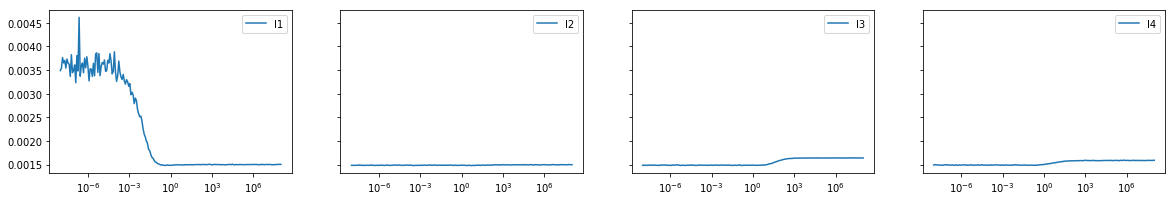

In [296]:
fig, ax = plt.subplots(figsize=(20, 3), nrows=1, ncols=4, sharex=True, sharey=True)

l_scan = 10**(np.linspace(-8,8,201))
l_opt = [0.630957, 0.630957, 0.398107, 0.158489]
for k,curr_l in enumerate(['l1','l2','l3','l4']):
    l1, l2, l3, l4 = l_opt
    mse = []
    for l_val in l_scan:
        curr_mse = 0
        for m in np.arange(mcreps):
            for train_index, test_index in kf.split(rn):
                # get data split
                trainset_F = raw_F[:,train_index]
                trainset_Y = raw_Y[:,train_index]
                testset_F = raw_F[:,test_index]
                testset_Y = raw_Y[:,test_index]

                # train the model
                D = np.zeros((raw_Y.shape[0], raw_Y.shape[0]));
                if curr_l == 'l1':
                    np.fill_diagonal(D, [l_val]*raw_Y_bacteria.shape[0] + [l2]*raw_Y_1.shape[0] + [l3]*raw_Y_inulin.shape[0] + [l4]*raw_Y_SCFA.shape[0])
                if curr_l == 'l2':
                    np.fill_diagonal(D, [l1]*raw_Y_bacteria.shape[0] + [l_val]*raw_Y_1.shape[0] + [l3]*raw_Y_inulin.shape[0] + [l4]*raw_Y_SCFA.shape[0])
                if curr_l == 'l3':
                    np.fill_diagonal(D, [l1]*raw_Y_bacteria.shape[0] + [l2]*raw_Y_1.shape[0] + [l_val]*raw_Y_inulin.shape[0] + [l4]*raw_Y_SCFA.shape[0])
                if curr_l == 'l4':
                    np.fill_diagonal(D, [l1]*raw_Y_bacteria.shape[0] + [l2]*raw_Y_1.shape[0] + [l3]*raw_Y_inulin.shape[0] + [l_val]*raw_Y_SCFA.shape[0])
                Coef = np.matmul(np.matmul(trainset_F,trainset_Y.transpose()), np.linalg.inv(np.matmul(trainset_Y, trainset_Y.transpose())+D))

                # mean square error of test dataset
                curr_mse += mean_squared_error(testset_F, np.matmul(Coef,testset_Y))
        curr_mse = curr_mse/kfold/mcreps
        mse.append(curr_mse)
        
    ax[k].plot(l_scan, mse, label=curr_l)
    ax[k].set_xscale('log')
    ax[k].legend()

# Estimate parameter values

In [13]:
df_cv_30 = pd.read_csv('lambda_selection_top30_v2.csv',index_col=0)
l1,l2,l3,l4 = list(df_cv_30.iloc[0][['l1','l2','l3','l4']])
l2=1e10
l4=1e10
D_final = np.zeros((raw_Y.shape[0], raw_Y.shape[0]))
np.fill_diagonal(D_final, [l1]*raw_Y_bacteria.shape[0] + [l2]*raw_Y_1.shape[0] + [l3]*raw_Y_inulin.shape[0] + [l4]*raw_Y_SCFA.shape[0])
Coef_final = np.matmul(np.matmul(raw_F,raw_Y.transpose()), np.linalg.inv(np.matmul(raw_Y, raw_Y.transpose())+D_final))

In [14]:
df_glv_res = pd.DataFrame(Coef_final, index=bacterial_taxons, columns=bacterial_taxons+list(['Growth','Inulin','Acetate','Butyrate','Propionate'])).reset_index()
df_glv_res = df_glv_res.rename({'index':'Taxon'}, axis=1)
df_glv_res.head()

,Taxon,Muribaculaceae,Akkermansia-muciniphila,Bacteroides-acidifaciens,Bacteroides,Faecalibaculum,Parasutterella,Bacteroides-uniformis,Alloprevotella,Parabacteroides-goldsteinii,...,Ruminococcaceae,Bacteroides-vulgatus-ATCC-8482,Roseburia,Rikenella,Anaerotruncus,Growth,Inulin,Acetate,Butyrate,Propionate
0,Muribaculaceae,-0.012473,-0.075565,0.037311,-0.107307,0.021703,-0.034907,-0.062633,0.018890,0.019585,...,0.014856,-0.028160,0.029019,0.019500,0.010548,3.089777e-11,0.066629,-8.539472e-11,-5.007295e-11,-4.253989e-11
1,Akkermansia-muciniphila,-0.006637,0.050250,0.050180,0.009033,0.007168,0.008613,-0.016131,0.002284,-0.011755,...,0.001618,-0.002475,0.010995,-0.001374,0.001574,-2.436224e-11,0.001801,-1.128782e-11,-3.206641e-12,-1.593935e-12
2,Bacteroides-acidifaciens,-0.115663,-0.198783,0.019377,-0.255317,-0.008801,-0.088880,-0.003180,0.033817,0.092126,...,0.006396,-0.028973,0.019284,0.020022,0.007210,8.847846e-11,0.106718,-8.803685e-11,-6.603994e-11,-6.128638e-11
3,Bacteroides,-0.031603,-0.018964,0.005775,-0.055727,-0.002017,-0.018148,0.003862,0.014809,-0.038609,...,-0.000173,-0.006422,0.002723,0.002879,0.000456,5.786140e-12,0.018721,-1.147670e-11,-8.067146e-12,-8.246081e-12
4,Faecalibaculum,-0.028953,-0.047063,-0.011434,-0.063184,0.002971,-0.020650,-0.005801,0.006653,0.004921,...,0.001244,-0.007157,0.004301,0.004777,0.001260,2.416294e-11,0.028568,-1.768577e-11,-1.498905e-11,-1.249882e-11


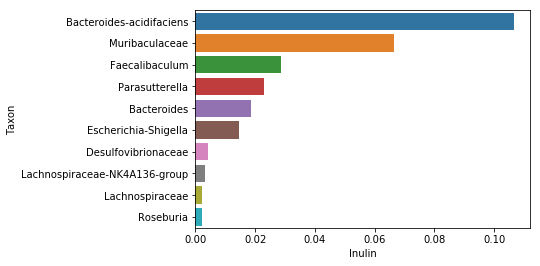

In [15]:
sns.barplot(y='Taxon', 
            x='Inulin', 
            data=df_glv_res[['Taxon','Inulin']].sort_values(by='Inulin',ascending=False).iloc[0:10],
            orient='h')

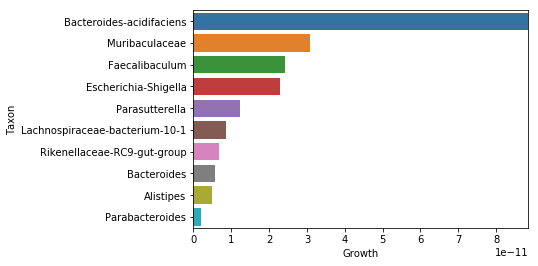

In [16]:
sns.barplot(y='Taxon', 
            x='Growth', 
            data=df_glv_res[['Taxon','Growth']].sort_values(by='Growth',ascending=False).iloc[0:10],
            orient='h')

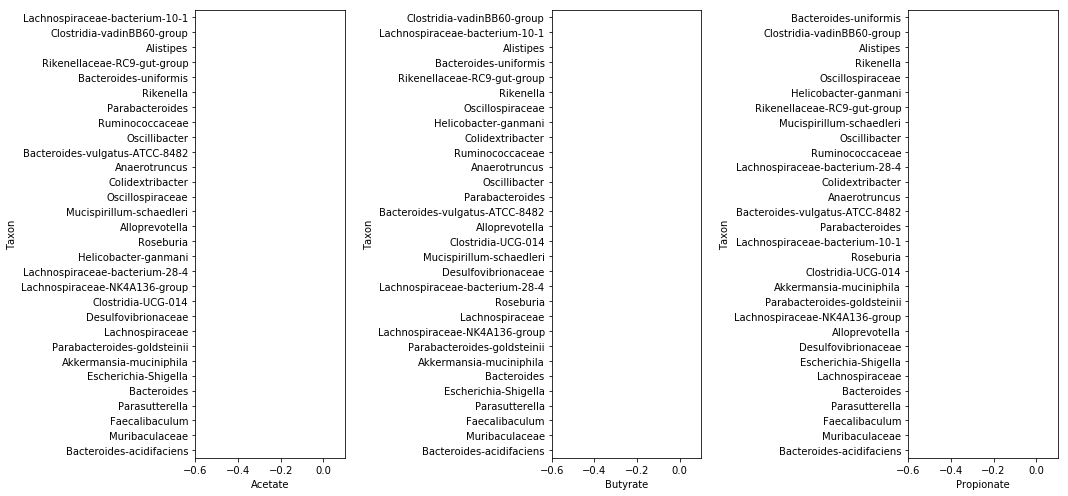

In [18]:
fig, ax = plt.subplots(figsize=(15, 7), nrows=1, ncols=3)
for k,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    sns.barplot(y='Taxon', 
                x=scfa, 
                data=df_glv_res[['Taxon',scfa]].sort_values(by=scfa,ascending=False),
                ax=ax[k],
                orient='h')
    ax[k].set_xlim([-0.6,0.1])
plt.tight_layout()

In [22]:
df_glv_res.head()

,Taxon,Muribaculaceae,Akkermansia-muciniphila,Bacteroides-acidifaciens,Bacteroides,Faecalibaculum,Parasutterella,Bacteroides-uniformis,Alloprevotella,Parabacteroides-goldsteinii,...,Ruminococcaceae,Bacteroides-vulgatus-ATCC-8482,Roseburia,Rikenella,Anaerotruncus,Growth,Inulin,Acetate,Butyrate,Propionate
0,Muribaculaceae,-0.012473,-0.075565,0.037311,-0.107307,0.021703,-0.034907,-0.062633,0.018890,0.019585,...,0.014856,-0.028160,0.029019,0.019500,0.010548,3.089777e-11,0.066629,-8.539472e-11,-5.007295e-11,-4.253989e-11
1,Akkermansia-muciniphila,-0.006637,0.050250,0.050180,0.009033,0.007168,0.008613,-0.016131,0.002284,-0.011755,...,0.001618,-0.002475,0.010995,-0.001374,0.001574,-2.436224e-11,0.001801,-1.128782e-11,-3.206641e-12,-1.593935e-12
2,Bacteroides-acidifaciens,-0.115663,-0.198783,0.019377,-0.255317,-0.008801,-0.088880,-0.003180,0.033817,0.092126,...,0.006396,-0.028973,0.019284,0.020022,0.007210,8.847846e-11,0.106718,-8.803685e-11,-6.603994e-11,-6.128638e-11
3,Bacteroides,-0.031603,-0.018964,0.005775,-0.055727,-0.002017,-0.018148,0.003862,0.014809,-0.038609,...,-0.000173,-0.006422,0.002723,0.002879,0.000456,5.786140e-12,0.018721,-1.147670e-11,-8.067146e-12,-8.246081e-12
4,Faecalibaculum,-0.028953,-0.047063,-0.011434,-0.063184,0.002971,-0.020650,-0.005801,0.006653,0.004921,...,0.001244,-0.007157,0.004301,0.004777,0.001260,2.416294e-11,0.028568,-1.768577e-11,-1.498905e-11,-1.249882e-11


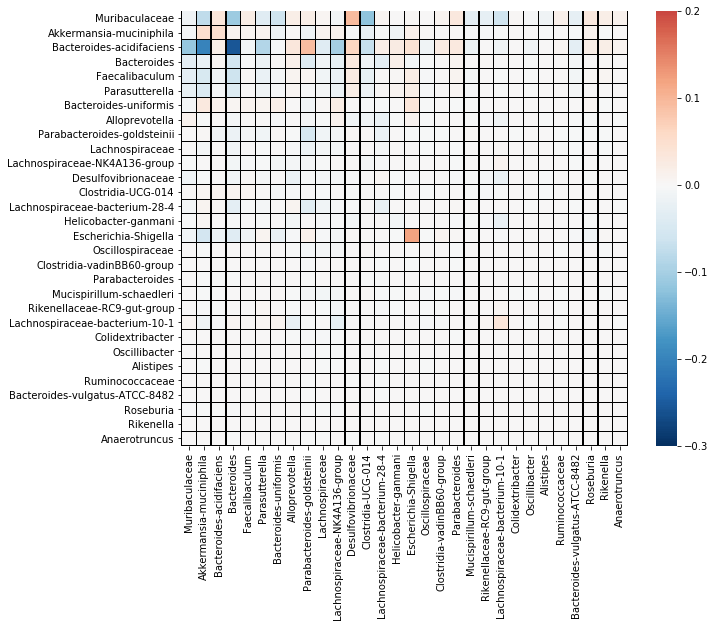

In [50]:
df_int = df_glv_res.set_index('Taxon').iloc[0:topX,0:topX]

fig, ax = plt.subplots(figsize=(10, 8), nrows=1, ncols=1)
sns.heatmap(df_int.values,
            cmap="RdBu_r",
            vmin=-0.3,
            vmax=0.2,
            center=0,
            xticklabels=df_int.index,
            yticklabels=df_int.index,
            linewidths=0.25,
            linecolor='k',
            ax=ax)